In [62]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import pyrsm as rsm
import seaborn as sns
from random import random, gauss, seed

### - Null hypothesis (H0): There is no difference in outcomes (open rate, click rate, donation transactions, total donation amount) between the control and treatment groups. 
### - Alternative hypothesis (H1): There is a difference in outcomes between the control and treatment groups.

### Overview Data Input

In [2]:
control_group = {'recipients': 2715, 'opened': 1388, 'clicked': 28, 'donations': 15, 'total_amount': 419.72}
treatment_group = {'recipients': 2714, 'opened': 1365, 'clicked': 21, 'donations': 3, 'total_amount': 21.20}


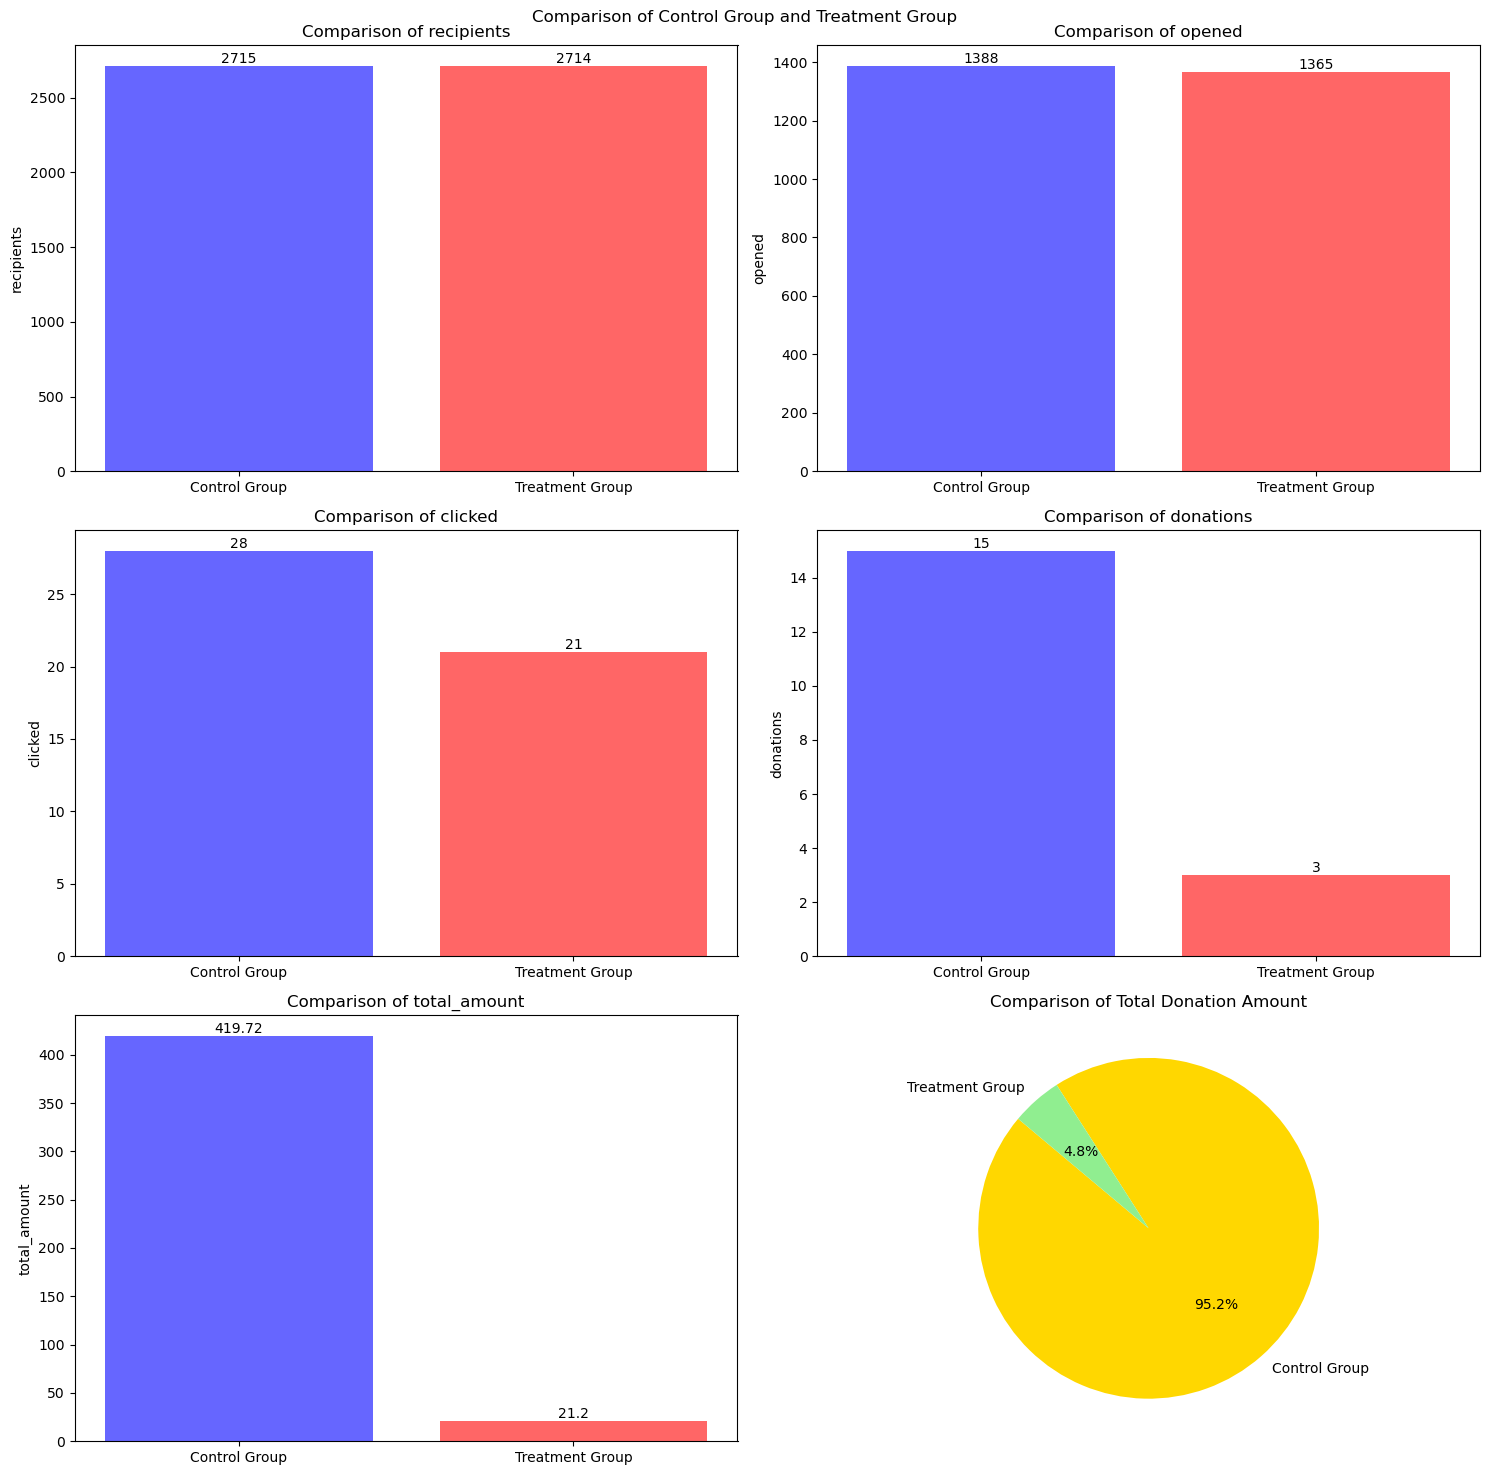

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  

metrics = ['recipients', 'opened', 'clicked', 'donations', 'total_amount']

for i, ax in enumerate(axs.flat):
    if i < len(metrics):  
        metric = metrics[i]
        bars1 = ax.bar('Control Group', control_group[metric], color='b', alpha=0.6)
        bars2 = ax.bar('Treatment Group', treatment_group[metric], color='r', alpha=0.6)

        ax.text(bars1[0].get_x() + bars1[0].get_width() / 2, bars1[0].get_height(), str(control_group[metric]), 
            ha='center', va='bottom')
        ax.text(bars2[0].get_x() + bars2[0].get_width() / 2, bars2[0].get_height(), str(treatment_group[metric]), 
            ha='center', va='bottom')

        ax.set_ylabel(metric)
        ax.set_title(f'Comparison of {metric}')
    elif i == len(metrics): 
        wedges, texts, autotexts = ax.pie([control_group['total_amount'], treatment_group['total_amount']],
               labels=['Control Group', 'Treatment Group'], autopct='%1.1f%%',
               colors=['gold', 'lightgreen'], startangle=140)  
        ax.set_title('Comparison of Total Donation Amount')
        
        for autotext in autotexts:
            autotext.set_color('black')

fig.suptitle('Comparison of Control Group and Treatment Group')

plt.tight_layout()
plt.show()

#### Recipients: The control group and the treatment group were almost identical in size, with 2715 and 2714 recipients respectively. This ensures a fair comparison between the two groups.

#### Opened: The control group had a slightly higher open rate than the treatment group, with 1388 opens compared to 1365. This suggests that the control group's email might have been slightly more appealing or noticeable.

#### Clicked: The control group also had a higher click rate, with 28 clicks compared to the treatment group's 21. This could indicate that the content or call-to-action in the control group's email was more engaging.

#### Donations: The control group had significantly more donations than the treatment group, with 15 donations compared to just 3. This is a strong indication that the control group's email was more effective at encouraging donations.

#### Total Amount: The control group also raised significantly more money, with a total donation amount of $419.72 compared to the treatment group's $21.20. This further supports the conclusion that the control group's email was more effective.

#### In conclusion, the data suggests that there is a significant difference in outcomes between the control and treatment groups, with the control group performing better in all measured outcomes. Therefore, we would reject the null hypothesis (H0) and accept the alternative hypothesis (H1). However, further statistical tests could be performed to confirm these findings.

### Donation Data Input 

(spreadsheet data is available, however, I will manually enter each record for the sake of convenience and reproducibility, with the assistance of AI)

In [24]:
donation = pd.read_csv('CampaignDonationHistory.csv')
donation['Gross'] = donation['Gross'].replace('[\$,]', '', regex=True).astype(float)
donation['balance'] = donation.groupby('Group')['Gross'].cumsum()

donation

,Date,Time (PST),Group,PaymentMethod,Gross,Fees,Net,balance
0,2/14/24,8:30:19,Control,PayPal,25.00,($0.99),$24.01,25.00
1,2/14/24,8:32:55,Control,PayPal,5.00,($0.59),$4.41,30.00
2,2/14/24,8:36:35,Control,PayPal,26.01,($1.01),$25.00,56.01
3,2/14/24,8:45:47,Control,PayPal,10.00,($0.69),$9.31,66.01
4,2/14/24,8:45:58,Control,PayPal,26.01,($1.01),$25.00,92.02
5,2/14/24,8:46:04,Control,PayPal,10.70,($0.70),$10.00,102.72
6,2/14/24,8:47:13,Treatment,PayPal,10.00,($0.69),$9.31,10.00
7,2/14/24,8:48:10,Control,PayPal,5.60,($0.60),$5.00,108.32
8,2/14/24,9:27:36,Control,PayPal,10.70,($0.70),$10.00,119.02
9,2/14/24,9:30:16,Control,PayPal,10.00,($0.69),$9.31,129.02


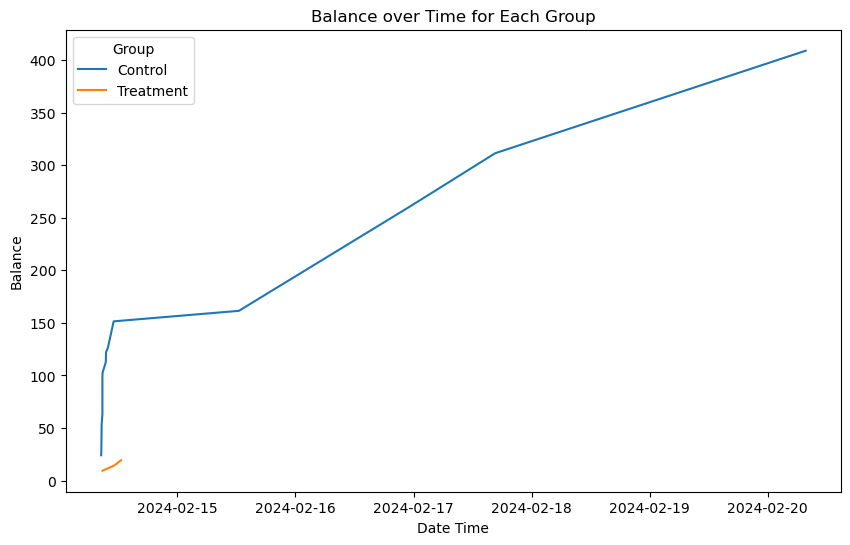

In [29]:
# Remove dollar signs and convert 'Net' to float
donation['Net'] = donation['Net'].replace('[\$,]', '', regex=True).astype(float)

# Calculate cumulative balance for each group
donation['balance'] = donation.groupby('Group')['Net'].cumsum()

# Convert 'Date' and 'Time (PST)' to string, merge them, and convert back to datetime
donation['date_time'] = pd.to_datetime(donation['Date'].dt.strftime('%Y-%m-%d') + ' ' + donation['Time (PST)'])

# Sort the data by 'Group' and 'date_time'
donation = donation.sort_values(['Group', 'date_time'])

# Plot
plt.figure(figsize=(10,6))
for group in donation['Group'].unique():
    plt.plot(donation[donation['Group'] == group]['date_time'], donation[donation['Group'] == group]['balance'], label=group)
plt.xlabel('Date Time')
plt.ylabel('Balance')
plt.title('Balance over Time for Each Group')
plt.legend(title='Group')
plt.show()

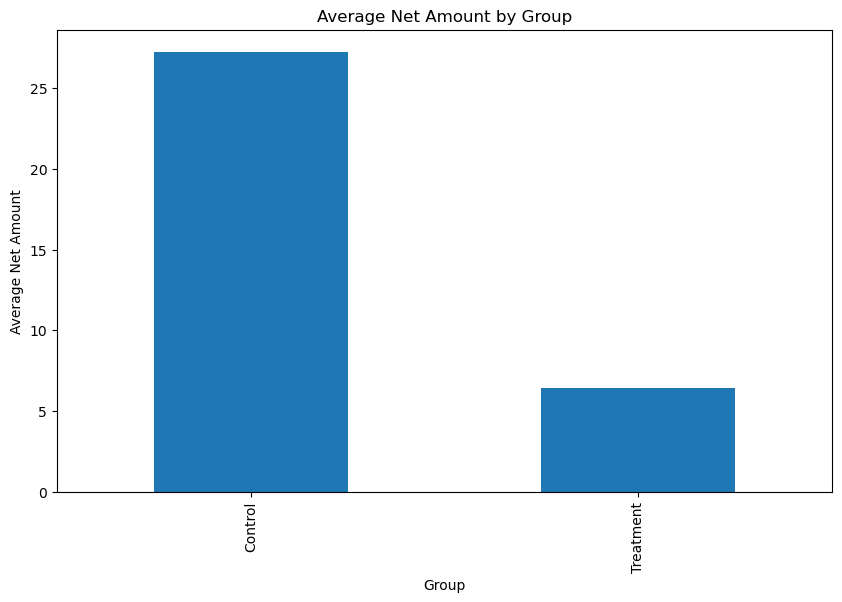

In [31]:
# Remove dollar signs and parentheses, and convert 'Net' to float
donation['Net'] = donation['Net'].replace('[\$,()]', '', regex=True).astype(float)

# Group by 'Group' and calculate mean 'Net'
group_net = donation.groupby('Group')['Net'].mean()

# Plot
group_net.plot(kind='bar', figsize=(10,6))
plt.xlabel('Group')
plt.ylabel('Average Net Amount')
plt.title('Average Net Amount by Group')
plt.show()

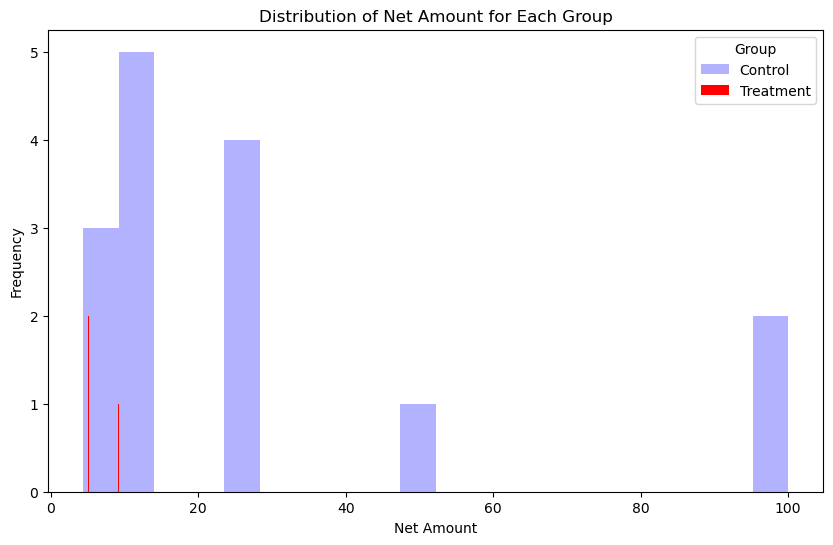

In [45]:
# Define colors and alphas for each group
colors = {'Control': 'blue', 'Treatment': 'red'}
alphas = {'Control': 0.3, 'Treatment': 1}

# Plot
plt.figure(figsize=(10,6))
for group in donation['Group'].unique():
    plt.hist(donation[donation['Group'] == group]['Net'], bins=20, alpha=alphas[group], label=group, color=colors[group])
plt.xlabel('Net Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Net Amount for Each Group')
plt.legend(title='Group')
plt.show()

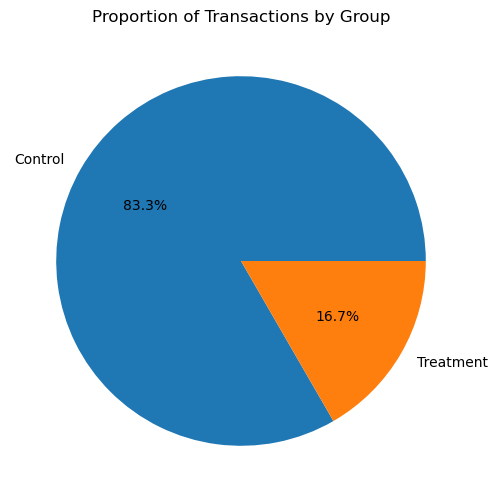

In [49]:
# Calculate the number of transactions in each group
group_counts = donation['Group'].value_counts()

# Plot
plt.figure(figsize=(10,6))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%')
plt.title('Proportion of Transactions by Group')
plt.show()

/tmp/ipykernel_6459/2721194691.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  donation['Hour'] = pd.to_datetime(donation['Time (PST)']).dt.hour


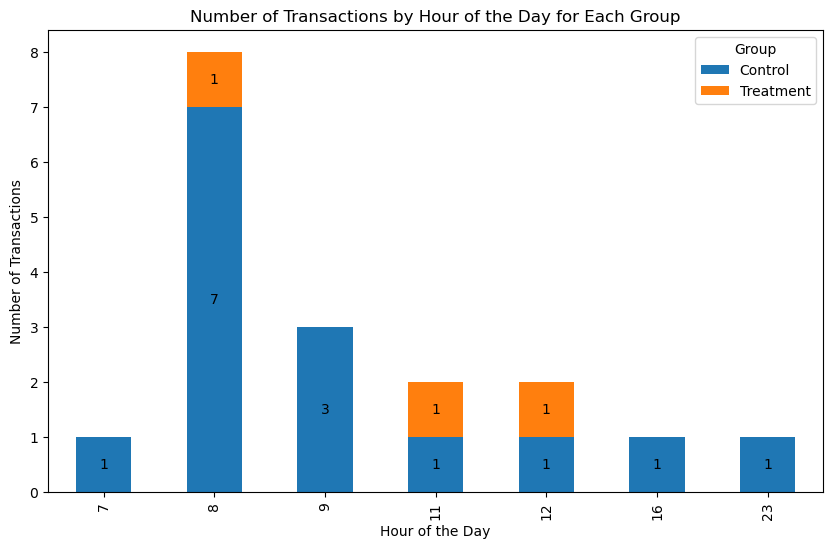

In [56]:
# Convert 'Time (PST)' to datetime and extract hour
donation['Hour'] = pd.to_datetime(donation['Time (PST)']).dt.hour

# Count the number of transactions per hour for each group
hourly_transactions_group = donation.groupby(['Hour', 'Group'])['Group'].count().unstack()

# Plot
ax = hourly_transactions_group.plot(kind='bar', stacked=True, figsize=(10,6))

# Add data labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0: 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Hour of the Day for Each Group')
plt.legend(title='Group')
plt.show()

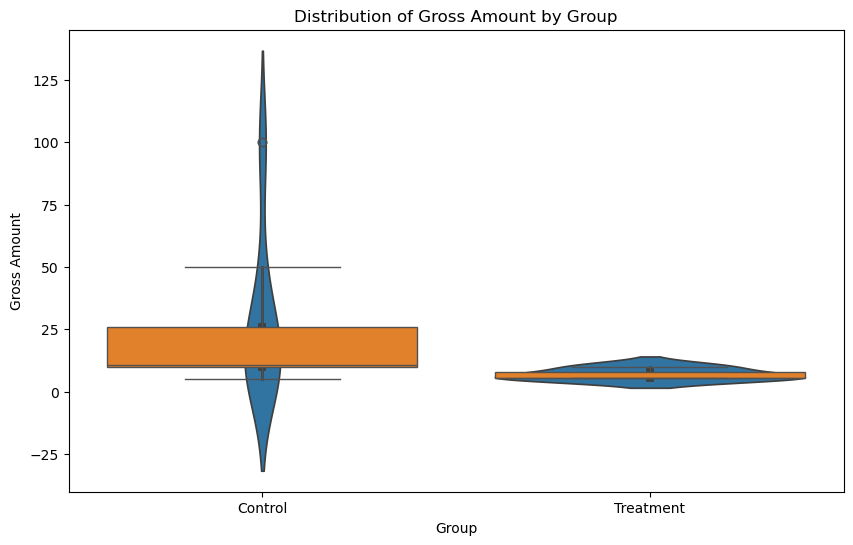

In [77]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Group', y='Gross', data=donation)
sns.boxplot(x='Group', y='Gross', data=donation)
plt.xlabel('Group')
plt.ylabel('Gross Amount')
plt.title('Distribution of Gross Amount by Group')
plt.show()

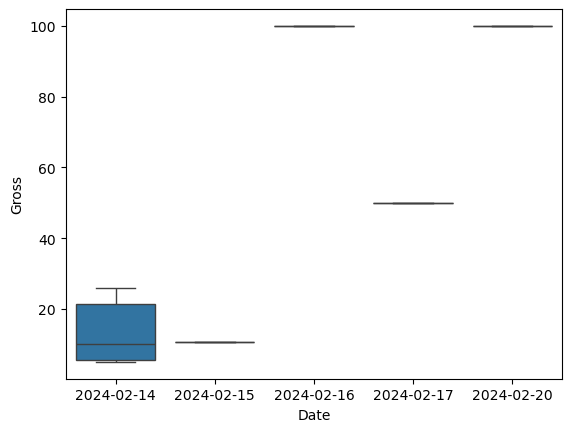

In [87]:
sns.boxplot(x='Date', y='Gross', data=donation)
plt.show()